# **딥러닝팀 클린업 2주차 코딩 실습**

> Produced by 김예찬 (feat. 구글링, 지멘)

## **0. 기본 설정**

### **0-1) Drive Mount**

In [1]:
# Drive Mount

from google.colab import drive
drive.mount('/content/gdrive')

# Working Directory 변경

import os

directory = "2022PSAT/[딥러닝팀]클린업 2주차 코딩 실습" # 파일이 있는 디렉토리
path = "/content/gdrive/My Drive/" + directory
os.chdir(path)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### **0-2) 한글 깨짐 현상**

---
> Jupyter Notebook과 마찬가지로 Colab에서 matplotlib에 한글을 표시하려고 하면 네모칸이 뜨면서 깨집니다. 이를 해결하기 위해 미리 한글 폰트를 적용하겠습니다. 나중에도 요긴하게 쓰입니다!

> 아래 코드를 실행한 후, '런타임' - '런타임 다시 시작'을 누른 후, 다시 한 번 실행하면 matplotlib의 plot에 정상적으로 한글이 나타납니다.

> *(이 코드는 이해할 필요 없습니다! 그냥 필요할 때마다 긁어서 쓰면 됩니다)*
---

In [2]:
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import matplotlib as mpl

!apt-get update -qq
!apt-get install fonts-nanum* -qq

path = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf' 
font_name = fm.FontProperties(fname=path, size=10).get_name()
print(font_name)
plt.rc('font', family=font_name)

fm._rebuild()
mpl.rcParams['axes.unicode_minus'] = False
font = fm.FontProperties(fname=path, size=9)
plt.rc('font', family='NanumBarunGothic')

NanumBarunGothic


### **0-3)패키지 불러오기**

In [3]:
import os
import sys
import glob                                          # os와 유사
import time                                          # 학습 소요 시간 측정
import cv2                                           # pip install opencv-python
import torch                                         # Pytorch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random
import datetime
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import albumentations as A
import torch.backends.cudnn as cudnn
from tqdm.notebook import tqdm                       # 진행률 확인
from PIL import Image, ImageOps
from scipy.spatial import ConvexHull
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from albumentations.pytorch import ToTensorV2         # Data Augmentation
from sklearn.model_selection import train_test_split

### **0-4) 시드 고정**

In [4]:
import random
import numpy as np

def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
random_state = 42
seed_everything(random_state)

torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.cuda.manual_seed_all(42)
cudnn.benchmark = False
cudnn.deterministic = True

## **1. 데이터 전처리**

---
> 본격적으로 클린업 2주차에서 배운 내용을 직접 구현해보겠습니다. CV(Computer VIsion)의 다양한 주제 중 가장 간단한 이미지 분류(Image Classification)를 위한 CNN 모델을 구현해보겠습니다.

> zip 파일에 첨부되어 있는 'train'과 'test' 폴더, 그리고 train.csv, test.csv를 원하는 경로에 저장하고, working directory를 변경해주세요!
---


### **1-1) 데이터 불러오기**

---
> 오늘 분류해볼 이미지 데이터는 우리나라의 랜드마크 이미지들입니다. 총 10가지의 랜드마크가 있으며, 각 사진이 어떤 랜드마크의 사진인지 예측해봅시다!

> 분석을 하기 전에 항상 데이터의 분포와 개요에 대해 정확히 파악하는 습관이 중요합니다. 따라서, 모델을 만들기 전에 항상 EDA를 통해 데이터를 파악한 후 모델링을 시작해야 합니다. 하지만 오늘은 딥러닝 모델 구현 실습이 목표이기 때문에, 생략하도록 하겠습니다.
---

In [5]:
# 데이터 불러오기

data = pd.read_csv('./train.csv',encoding='utf8')
test = pd.read_csv('./test.csv', encoding='utf8')

# 데이터 수 확인

print('학습 데이터 수   : %d' % (data.shape[0]))
print('테스트 데이터 수 : %d' % (test.shape[0]))

학습 데이터 수   : 735
테스트 데이터 수 : 184


In [6]:
# 랜드마크 라벨 목록

landmarks_class = [
    '서울한양도성',
    '충무공 이순신 동상',
    '김포국제공항',
    '세빛섬',
    '정릉',
    '양화대교',
    '서울광장',
    '북촌 한옥마을',
    '롯데월드타워',
    '경복궁'
]

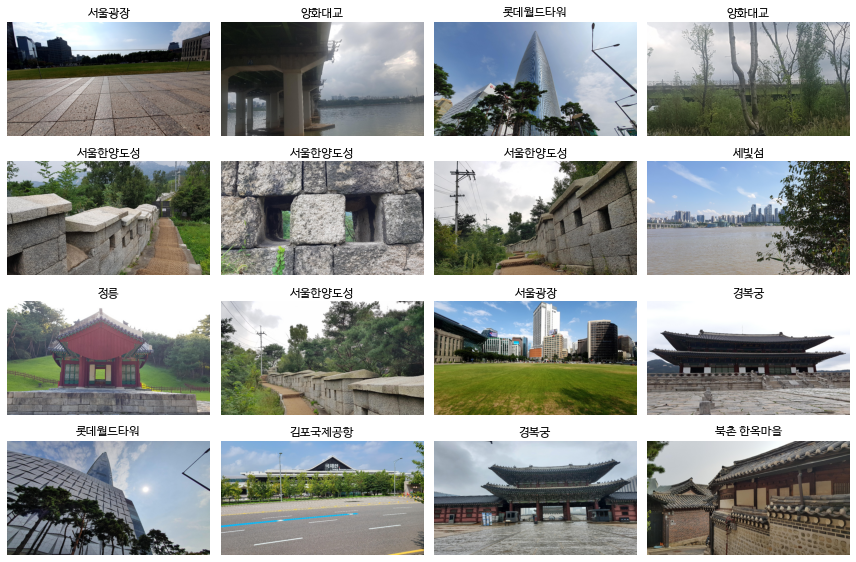

In [7]:
# 데이터 확인

plt.figure(figsize=(12,8))
for n, (idx, row) in enumerate(data.sample(16).iterrows(), start=1):
    plt.subplot(4,4, n)
    img = plt.imread(row['path'])
    plt.imshow(img)
    plt.title(landmarks_class[row['class']])
    plt.axis('off')
plt.tight_layout()
plt.show()

### **1-2) 데이터 분할**

---
> 데이터는 많으면 많을수록 좋지만, 데이터가 많은 경우는 흔치 않습니다. 따라서, 주어진 데이터를 학습 데이터(train set)과 검증 데이터(validation set)으로 분할하는 과정은 생각보다 정교한 방법이 필요합니다.

> 오늘은 가장 기본적인 방법인 임의 추출로 분할하도록 하겠습니다.
---

In [8]:
# train set, validation set 분할
# 'test_size'를 통해 validation set의 비율을 설정

train, valid = train_test_split(data, test_size=0.2, random_state=42)

### **1-3) 데이터 변환**

---
> 이미지, 자연어, 음성, 영상 등은 딥러닝의 대표적인 응용 분야입니다. 그렇다면 어떻게 딥러닝 모델은 .jpg, .txt, .wav, .mp4 등의 파일을 입력받아 결과를 출력할까요?

> 어떤 주제에서든 이들을 컴퓨터가 이해할 수 있는 형태로 바꾸어주는 작업이 필수적입니다. 구체적으로 말하자면, GPU에서 연산이 가능한 형태인 tensor로 바꾸어주는 작업이 필수적입니다. 딥러닝 모델을 만드는 것보다 어쩌면 이 부분이 더 어려울 수도 있습니다!
---

In [9]:
# 이미지를 tensor로 바꿔주는 class 정의

class LandmarksDataset(Dataset):
    def __init__(self, data, transforms):                                 # data = 입력 데이터, transforms = Data Augmentation
        self.data = data
        self.transforms = transforms

    def __len__(self):                                                    # 데이터의 길이를 데이터의 개수로 지정합니다
        return self.data.shape[0]

    def __getitem__(self, index: int):
        assert index <= len(self), 'index range error'                    # __getitem__: 데이터 인덱싱이 가능하도록 합니다

        image = plt.imread(self.data.iloc[index, ]['path'])
        image = np.array(image)                                           # 이미지를 array 형식으로 만듭니다 (행렬로 바꾼다고 이해하시면 됩니다)
        
        target = torch.as_tensor(self.data.iloc[index, ]['class'])        # 딥러닝을 위해서는 항상 tensor로 변환해주어야 합니다!!!!!

        if self.transforms is not None:                                   # Data Augmentation을 적용합니다 
            image = self.transforms(image=image)['image']                 # (추후 성능을 향상 시켜보고 싶으면 제거해보고 해보세요!)

        return image, target                                              # image = 입력 데이터 (X), target = 정답 (y)

Class는 객체지향 언어로써의 python의 성격을 잘 보여주는 부분입니다. 객체지향 언어를 쉽게 이해할 수 있는 예시를 하나 살펴보겠습니다. '귀가 뾰족하다', '귀엽다'라는 속성을 가지는 '강아지'라는 class를 새로 정의하면, '강아지'라는 class에 속하는 '시바', '말티즈', '진돗개' 등의 객체를 만들 수 있습니다. 이 객체들은 '강아지'라는 class에 속하기 때문에 공통적으로 '귀엽다'라는 속성을 가지게 되는 것입니다. Class가 이번 실습의 주제는 아니기 때문에, 이 정도로 이해하고 넘어가겠습니다!

### **1-4) Data Augmentation**

---
> 정형 데이터를 분석하기 위한 모델을 만들 때 학습 데이터의 수가 부족하거나 특정 라벨의 데이터가 부족한 경우, SMOTE 등의 오버샘플링 기법을 통해 데이터의 수를 늘리는 것이 가능합니다. 마찬가지로, 이미지와 같은 비정형 데이터 역시 데이터의 수를 인위적으로 늘려줄 수 있는데, 이를 Data Augmentation이라고 합니다. 이미지 데이터의 경우 데이터가 적으면 원본 이미지에 노이즈를 추가한 이미지들을 만들어 실제 주어진 학습 데이터보다 많은 양의 데이터를 학습에 사용할 수 있습니다.

> 이미지 데이터를 예로 들면, 이미지 반전, 회전, 명도 조절, 채도 조절 등의 다양한 방법으로 데이터에 노이즈를 추가할 수 있습니다.
---

In [14]:
# Data Augmentation

transforms_train = A.Compose([
        A.Resize(128, 128),                                         # (128, 128)로 size 변환
        A.HorizontalFlip(p=0.5),                                    # 좌우반전
        A.RandomBrightnessContrast(p=0.3),                          # 채도 조절
        A.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),  # normalize
        ToTensorV2(),                                                 # tensor로 변환
])

transforms_valid = A.Compose([
    A.Resize(128, 128),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.3),
    A.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ToTensorV2(),
])

# 원래 Data Augmentation을 적용한 이미지들을 저장해야 데이터의 수를 늘릴 수 있지만,
# 오늘은 Data Augmentation이 어떤 것인지만 보고 넘어가겠습니다!

### **1-5) DataLoader 준비**

---
> DataLoader는 우리가 가지고 있는 가공되지 않은 데이터를 위에서 정의한 class와 data augmentation을 적용하여 최종적으로 모델에 입력할 수 있는 데이터의 형태를 만들어주기 위해 필요한 개념입니다.

> 따라서, dataloader의 출력값은 다음과 같습니다.



1.   tensor 변환 + data augmentation 적용된 이미지 데이터
2.   해당 데이터의 label

> 그리고 우리가 원하는 batch size를 지정하여 한 번에 원하는 개수의 {이미지 데이터(tensor), label}을 반환하도록 합니다.
---


In [15]:
# DataLoader 1단계 - 위에서 정의한 class를 활용하여 데이터를 학습에 필요한 형태로 변환

train_dataset = LandmarksDataset(data=train, transforms=transforms_train)
valid_dataset = LandmarksDataset(data=valid, transforms=transforms_valid)

In [19]:
train.shape[0]

588

In [31]:
train_dataset[1][0]

tensor([[[ 2.0777,  2.0092,  1.8037,  ...,  0.5536,  0.5536,  0.5536],
         [ 1.9578,  2.0434,  2.1633,  ...,  0.5707,  0.5707,  0.5878],
         [ 1.9407,  2.0263,  2.0605,  ...,  0.6049,  0.5364,  0.5536],
         ...,
         [-0.4568, -0.9363, -0.8849,  ...,  0.7933,  0.7419,  0.8276],
         [-0.7479, -0.7993, -0.7993,  ...,  0.5878,  0.8276,  0.8961],
         [-0.2171, -0.7137, -0.6623,  ...,  0.7591,  0.4337,  0.1597]],

        [[ 2.2010,  2.1660,  2.0259,  ...,  1.2206,  1.2206,  1.2206],
         [ 2.0959,  2.1660,  2.2885,  ...,  1.2381,  1.2381,  1.2731],
         [ 2.0784,  2.1660,  2.2360,  ...,  1.2731,  1.1856,  1.1681],
         ...,
         [-0.4076, -0.8277, -0.7052,  ...,  0.6604,  0.6779,  0.7654],
         [-0.6877, -0.7227, -0.7402,  ...,  0.3978,  0.6429,  0.7129],
         [-0.3025, -0.7927, -0.7752,  ...,  0.5028,  0.3627,  0.0826]],

        [[ 2.2391,  2.1694,  2.3088,  ...,  1.9254,  1.9254,  1.9254],
         [ 2.0823,  2.2217,  2.3611,  ...,  1

In [16]:
# DataLoader 2단계 - torch 라이브러리의 DataLoader 함수를 사용하여 최종 입력 데이터 준비

batch_size = 8 # 성능 향상을 위해 이것저것 시도해보세요!

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

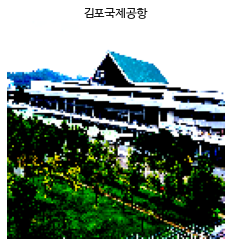

In [17]:
# Data Augmentation이 적용된 이미지 확인

images, targets = next(iter(train_dataloader))          # next(iter())를 활용하여 학습 데이터 dataloader에서 반환값 순차적으로 확인
plt.imshow(images[0].numpy().transpose(1,2,0))          # tensor로 변환되어 있는 값을 numpy array로 변환(plt는 array만 인식)
plt.title(landmarks_class[targets[0]])                 
plt.axis('off')
plt.show()

## **2. 모델링**

---
> 이제 모델을 만들어보겠습니다! Python에서 딥러닝 모델을 구축할 때 활용할 수 있는 라이브러리는 대표적으로 pytorch와 tensorflow가 있습니다. 라이브러리보다는 딥러닝 프레임워크라는 표현이 더 정확하지만, 비슷한 의미로 받아들이면 될 것 같습니다. 클린업에서도 언급했듯이 pytorch는 조금 더 연구에 적합하고, tensorflow는 직관적인 모델 구축에 강점을 가지고 있다고 합니다. 오늘과 앞으로 주제분석에서 저희는 pytorch를 사용할 예정입니다! 
---

### **2-1) 모델 정의**

---
> Pytorch에서 새로운 모델을 만드는 방법 중 가장 기본적인 방법을 공부해보겠습니다. 다음 단계들을 거쳐 새로운 모델을 정의할 수 있으며, 여기서부터는 꼭 한 줄 한 줄이 어떤 것들을 의미하는지 뜯어보면서 공부하면 좋을 것 같습니다!


1.   새로운 class 정의
2.   init 함수 정의 - 모델의 layer들을 순차적으로 정의
3.   forward 함수 정의 - forward propagation의 순서 정의
---



In [ ]:
# 모델 정의

class CNN(nn.Module):
    def __init__(self):                                   # init 함수란, class의 새로운 객체가 정의되었을 때 자동적으로 부여되는 속성들을 모아놓은 것
        super(CNN, self).__init__()                       # super() 안에는 순서대로 'class 이름', 'self'를 넣어줍니다.
        self.conv1 = nn.Conv2d(3, 8, 3, 1, padding=1)     # 첫 번째 Convolutional Layer - (in_channels, out_channels, window_size, stride)
        self.conv2 = nn.Conv2d(8, 16, 4, 2, padding=1)   # 두 번째 Convolutional Layer
        self.conv3 = nn.Conv2d(16, 32, 4, 2, padding=1)   # 세 번째 Convolutional Layer
        
        self.fc1 = nn.Linear(8192, 256)                   # 첫 번째 Fully Connected Layer - 왜 8192가 입력일까요?
        self.fc2 = nn.Linear(256, 10)                     # 두 번째 Fully Connected Layer

        nn.init.kaiming_normal_(self.conv1.weight)        # 각 Layer의 초기값을 설정하는 구간입니다.
        nn.init.kaiming_normal_(self.conv2.weight)        # nn.init.kaiming_normal_ 혹은 nn.init.xavier_uniform_을 보통 사용합니다.
        nn.init.kaiming_normal_(self.conv3.weight)
        nn.init.kaiming_normal_(self.fc1.weight)
        nn.init.kaiming_normal_(self.fc2.weight)
      
    def forward(self, x):                                 # 순전파 과정이 어떻게 되는지 머릿속으로 그려보면 좋습니다!
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        
        x = self.conv3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)                                   # 왜 마지막 출력층에서는 활성화 함수를 적용시키지 않았을까요?
        
        return x

### **2-2) 모델 준비**

---
> 위에서 정의한 모델을 학습시키기 위해서는 한 가지 중요한 단계를 거쳐야 합니다. 우리가 Colab을 사용하는 이유는 좋은 GPU를 사용할 수 있기 때문이었습니다. 따라서, 모델 학습 과정 전반의 연산을 GPU에서 진행할 수 있도록 GPU에 모델을 올린 후 학습을 진행해야 합니다!
---

In [ ]:
# 모델을 GPU에 올리기

model = CNN().to('cuda')

# 모델 개요 확인

print(model)

CNN(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (fc1): Linear(in_features=8192, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)


### **2-3) 모델 개요 확인**

---
> 딥러닝 모델의 성능을 높이기 위해 여러가지 layer들을 마구잡이로 넣는 경우를 흔히 볼 수 있습니다. 합리적인 이유에서 layer의 수와 종류를 늘리는 것은 좋지만, 어떤 layer들을 넣었는지, 왜 넣었는지를 생각하지 않고 넣을 경우 오히려 성능을 저하시킬 확률이 높으며, 설령 높아졌다 하더라도 그 이유를 알 수 없어 성능을 더욱 끌어올리기 힘들어집니다.

> 따라서, 항상 내가 어떤 모델을 만들고 있으며, 왜 그렇게 만들었는지를 이해하기 위해 모델의 개요를 확인해주어야 합니다. 지금부터는 모델의 개요를 확인하는 방법과 개요에서 어떤 것들을 주로 체크해야 하는지 알아보겠습니다.
---

In [ ]:
from torchsummary import summary

summary(model, input_size=(3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 128, 128]             224
            Conv2d-2           [-1, 16, 64, 64]           2,064
            Conv2d-3           [-1, 32, 32, 32]           8,224
            Linear-4                  [-1, 256]       2,097,408
            Linear-5                   [-1, 10]           2,570
Total params: 2,110,490
Trainable params: 2,110,490
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.19
Forward/backward pass size (MB): 1.75
Params size (MB): 8.05
Estimated Total Size (MB): 9.99
----------------------------------------------------------------


> 위 개요에서 중점적으로 확인해야 하는 것은 파라미터의 수와 사이즈입니다. 예측 속도는 딥러닝 모델에 있어 예측 정확도 못지않게 중요한 요소입니다. 그리고 파라미터의 수와 사이즈는 학습 및 예측 속도와 직결되어 있으므로, 성능이 동일할 때 수가 적고 사이즈가 작을수록 좋은 모델입니다. 이 경우 파라미터의 수가 2,110,490개이며, 사이즈는 8.05MB입니다. 모델이 매우 간단하기 때문에 파라미터 수가 그렇게 많지는 않은 것 같습니다!

> Conv. Layer에 비해 FC Layer가 파라미터 수에서 훨씬 큰 비중을 차지한다는 점을 확인하고 넘어가겠습니다.

## **3. 학습 및 평가**

### **3-1) 하이퍼 파라미터 설정**

-----
> 손실함수는 모델로 해결하고자 하는 과제가 이진 분류 과제인지, 다중 분류 과제인지, 그리고 회귀 문제인지에 따라 달라질 수 있습니다. 오늘 해결하고자 하는 문제는 라벨이 10개인 분류 문제, 즉 다중 분류 문제이기 때문에 pytorch의 CrossEntropyLoss()를 사용하도록 하겠습니다. 과제에 적합한 손실함수를 사용하지 않을 경우 오류가 발생해 모델이 학습되지 않으므로, 과제별 손실함수를 잘 알고 있는 것이 편합니다!

> Optimizer는 손실함수와 달리 특정 optimizer를 사용한다고 해서 오류가 발생하지는 않습니다. 다만, 어떤 optimizer를 사용하느냐에 따라 모델의 일반화 성능, 손실함수의 값이 0으로 수렴하는 속도 등에 있어 차이가 있을 수 있습니다. 즉, 성능에 유의미한 차이를 줄 수 있는 요소이기 때문에, 적절한 optimizer를 찾을 줄 알아야 합니다. 만약 확신이 서지 않는다면 Adam부터 적용해보는 것이 가장 좋은 선택입니다.
-----

In [ ]:
# Optimizer와 Loss Function 설정

optimizer = optim.SGD(model.parameters(), lr=2e-5, momentum=0.95)      # SGD + Momentum (성능 향상을 위해 Adam 등 다른 optimizer도 사용해보세요!)
loss_fn = nn.CrossEntropyLoss()                                        # 다중 분류를 위한 손실함수

### **3-2) 모델 학습**

-----
> 본격적으로 모델 학습을 시작해보겠습니다. 1주차에서 살펴본 바와 같이, 딥러닝에서 학습은 보통 손실함수의 값을 최소화시키는 과정을 따라 이루어지며, 그 과정에서 학습 데이터 및 검증 데이터에 대한 예측의 정확도가 올라가게 됩니다. 때문에, 손실함수 값의 변동 추이 또한 예측의 정확도만큼 중요한 평가 요소라고 할 수 있습니다. 따라서, 학습을 진행할 때 두 데이터에 대한 손실함수 값의 변동과 정확도의 변동을 항상 별도의 list에 저장해놓는 코딩 습관을 들여놓는 것이 좋습니다. 시간을 측정하는 습관도 마찬가지입니다!

> Epoch는 전체 데이터셋을 몇 번 재활용하여 학습을 진행할 것인지를 의미합니다. 아래와 같이 epoch가 30으로 되어 있으면, 전체 데이터셋을 30번 반복해서 학습할 것이라는 뜻입니다. 

> 아래의 학습 코드는 모델의 종류에 따라 조금은 바뀔 수 있겠지만, 큰 틀에서 딥러닝 모델들은 대부분 아래의 코드와 유사한 형태의 코드로 학습을 진행합니다. 따라서, 아래 코드를 잘 익혀두면 앞으로도 편하게 사용할 수 있습니다. 코드가 복잡하므로, 한 줄 한 줄 이해하고 넘어가길 바랍니다!
-----

In [ ]:
epochs = 30
train_losses = []
train_acces = []
valid_losses = []
valid_acces = []

start_time = time.time()

for epoch in range(epochs):
    
    #########
    # Train #
    #########
    model.train()
    train_loss = 0
    train_acc = 0
    for i, (images, targets) in enumerate(train_dataloader):
        images = images.to('cuda')
        targets = targets.to('cuda')

        scores = model(images)
        _, preds = scores.max(dim=1)
        loss = loss_fn(scores, targets)

        train_loss += loss
        train_acc += (targets == preds).sum() / preds.size(0)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    ##############
    # Validation #
    ##############
    model.eval()
    valid_loss = 0
    valid_acc = 0
    with torch.no_grad():
        for i, (images, targets) in enumerate(valid_dataloader):
            images = images.to('cuda')
            targets = targets.to('cuda')

            scores = model(images)
            _, preds = scores.max(dim=1)

            valid_loss += loss_fn(scores, targets)
            valid_acc += (targets == preds).sum() / preds.size(0)
            
    #######
    # Log #
    #######
    train_losses.append(train_loss.detach().cpu().numpy() / len(train_dataloader))
    train_acces.append(train_acc.detach().cpu().numpy() / len(train_dataloader))
    valid_losses.append(valid_loss.detach().cpu().numpy() / len(valid_dataloader))
    valid_acces.append(valid_acc.detach().cpu().numpy() / len(valid_dataloader))
        

    elapsed_time = time.time() - start_time
        
    print(f"[{time.strftime('%H:%M:%S', time.gmtime(elapsed_time))}] Epoch {epoch+1:2d} \
    Train Loss: {train_losses[-1]:6.4f} Train Acc: {train_acces[-1]:6.4f} \
    Valid Loss: {valid_losses[-1]:6.4f} Valid Acc: {valid_acces[-1]:6.4f}")

[00:00:12] Epoch  1     Train Loss: 2.3609 Train Acc: 0.1473     Valid Loss: 2.2224 Valid Acc: 0.1458
[00:00:22] Epoch  2     Train Loss: 1.8969 Train Acc: 0.3493     Valid Loss: 1.8668 Valid Acc: 0.3611
[00:00:31] Epoch  3     Train Loss: 1.6749 Train Acc: 0.4538     Valid Loss: 1.7690 Valid Acc: 0.4236
[00:00:40] Epoch  4     Train Loss: 1.4714 Train Acc: 0.5291     Valid Loss: 1.5540 Valid Acc: 0.4722
[00:00:50] Epoch  5     Train Loss: 1.3417 Train Acc: 0.5651     Valid Loss: 1.6122 Valid Acc: 0.4306
[00:00:59] Epoch  6     Train Loss: 1.2442 Train Acc: 0.5908     Valid Loss: 1.4031 Valid Acc: 0.5556
[00:01:09] Epoch  7     Train Loss: 1.0920 Train Acc: 0.6473     Valid Loss: 1.4167 Valid Acc: 0.5278
[00:01:19] Epoch  8     Train Loss: 1.0497 Train Acc: 0.6541     Valid Loss: 1.2818 Valid Acc: 0.5764
[00:01:29] Epoch  9     Train Loss: 0.9576 Train Acc: 0.7021     Valid Loss: 1.1673 Valid Acc: 0.6111
[00:01:38] Epoch 10     Train Loss: 0.8984 Train Acc: 0.7209     Valid Loss: 1.107

### **3-3) 결과 시각화**

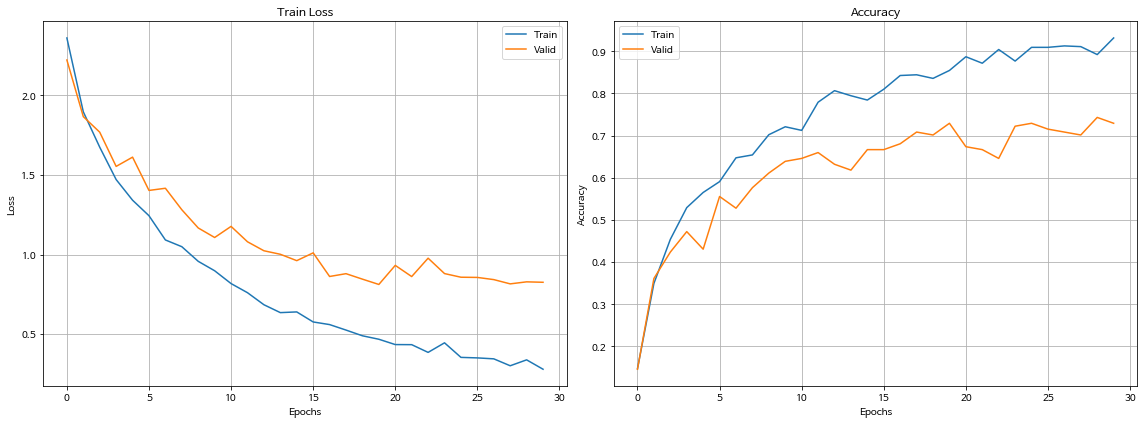

In [ ]:
plt.figure(figsize=(16,6))

# Loss 시각화

plt.subplot(1,2,1)
plt.plot(train_losses)
plt.plot(valid_losses)
plt.title('Train Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(['Train','Valid'])
plt.grid(True)

# Accuracy 시각화

plt.subplot(1,2,2)
plt.plot(train_acces)
plt.plot(valid_acces)
plt.title('Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(['Train','Valid'])
plt.grid(True)

plt.tight_layout()
plt.show()

### **3-4) 결과 분석**

----


1.   Loss 그래프를 보았을 때, Train Loss와 Valid Loss가 비슷한 속도로 감소하고 있음을 확인할 수 있으며, Train Loss가 0으로 수렴했기 때문에 모델이 데이터에 잘 적합되었음을 의미합니다. 다만, 약 15 epoch부터는 Train Loss와 비교했을 때 Valid Loss의 감소 속도가 현저히 떨어진 것으로 보아 과적합을 의심해볼 수 있습니다.

2.   Accuracy 그래프를 보았을 때, Epoch 초반에 빠른 속도로 정확도가 상승하고 있음을 확인할 수 있습니다. 약 0.95까지 수렴한 Train Accuracy와 달리 Valid Accuracy는 약 0.75에 수렴한 것을 확인할 수 있습니다. Loss 그래프에서와 마찬가지로 과적합을 의심해볼 수 있습니다. 

---

### **3-5) 개선 방안**

---


1.   과적합을 개선할 수 있는 방법이 무엇이 있을까요?
2.   모델의 성능을 전반적으로 향상시키기 위해 적용해볼 수 있는 방법에는 무엇이 있을까요? (Hint: Optimizer 변경, 다양한 Layer 추가, Batch Size 조절, Data Augmentation 적용/제거, Epoch 키우기 등)

> 위 질문들을 고민해보면서 성능을 최대한 올려보시기 바랍니다!
---



## **4. 마무리**

---
> 지금까지 파이썬 환경에서 어떻게 딥러닝 모델을 구현할 수 있는지 코드 실습을 통해 알아보았습니다. 파이썬 자체에 익숙하더라도 Pytorch는 생소할 확률이 높기 때문에, 이 코드 실습 자료의 코드들을 한 줄 한 줄 완벽히 이해하면서 넘어가는 것을 권장합니다. 특히 주제분석에서 거의 비슷한 과정을 통해 모델을 구축하고 학습할 예정이기 때문에, 코드 전개의 흐름 자체도 잘 이해하는 것이 좋습니다. 특히 아래 항목들은 확실한 이해가 필수적이며, 필요한 경우 구글 검색을 통해 관련 자료를 더 공부해보는 것을 추천드립니다.
---


1.   Colab 사용법 익숙해지기 (버튼 하나씩 다 눌러보는 것도 좋습니다)
2.   파이썬의 Class 개념 
    - 키워드: Class, 객체지향, 상속 등
    - 딥러닝을 떠나서 코딩을 공부할 때 도움이 매우 많이 됩니다!
3.   1-5 장의 DataLoader 구현 방법 공부 
    - 다양한 비정형 데이터를 다루기 위해서는 데이터 형식마다 적합한 DataLoader를 구현하는 능력이 필수적입니다!
4.   2-1 장의 모델 Class 정의 방법 공부
    - 2주차에 배운 CNN의 여러 종류, 그리고 RNN의 여러 종류 등 모델을 불문하고 모든 딥러닝 모델은 이 포맷을 바탕으로 합니다. 꼭 익숙해질 때까지 연습해보세요! (Pytorch 기준)
---




